In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score,train_test_split as tts
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score,f1_score
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Master\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Master\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Master\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df=pd.read_csv("rows.csv")
df.head()

C:\Users\Master\AppData\Local\Temp\ipykernel_11524\3529831897.py:1: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("rows.csv")


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,NaN,NAVY FEDERAL CREDIT UNION,FL,328XX,Older American,NaN,Web,05/10/2019,In progress,Yes,NaN,3238275
1,05/10/2019,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,NaN,NaN,BOEING EMPLOYEES CREDIT UNION,WA,98204,NaN,NaN,Referral,05/10/2019,Closed with explanation,Yes,NaN,3238228
2,05/10/2019,Debt collection,Payday loan debt,Communication tactics,Frequent or repeated calls,NaN,NaN,CURO Intermediate Holdings,TX,751XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3237964
3,05/10/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,NaN,NaN,Ad Astra Recovery Services Inc,LA,708XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3238479
4,05/10/2019,Checking or savings account,Checking account,Managing an account,Banking errors,NaN,NaN,ALLY FINANCIAL INC.,AZ,85205,NaN,NaN,Postal mail,05/10/2019,In progress,Yes,NaN,3238460


In [3]:
#Random taking sample of 60000 complaints to make model building simple
df=df.sample(n = 60000, replace = False) 
     

df.shape

(60000, 18)

Text(0, 0.5, 'Type of Complaint')

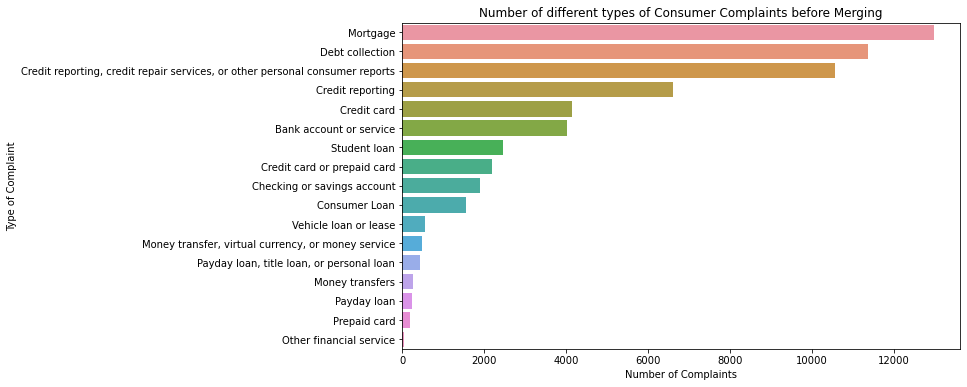

In [4]:
plt.figure(figsize=(10,6))
sns.barplot(x=df["Product"].value_counts(),y=df["Product"].value_counts().index)
plt.title("Number of different types of Consumer Complaints before Merging")
plt.xlabel("Number of Complaints")
plt.ylabel("Type of Complaint")

Merging the similar Product Complaints Type

In [5]:
#Merging complaints belonging to same department
df["Product"]=df["Product"].replace("Credit reporting","Credit reporting, credit repair services, or other personal consumer reports")
df["Product"]=df["Product"].replace("Credit card","Credit card or prepaid card")
df["Product"]=df["Product"].replace("Prepaid card","Credit card or prepaid card")
df["Product"]=df["Product"].replace("Virtual currency","Money transfer, virtual currency, or money service")
df["Product"]=df["Product"].replace("Payday loan","Payday loan, title loan, or personal loan")
df["Product"]=df["Product"].replace("Money transfers","Money transfer, virtual currency, or money service")

Text(0, 0.5, 'Type of Complaint')

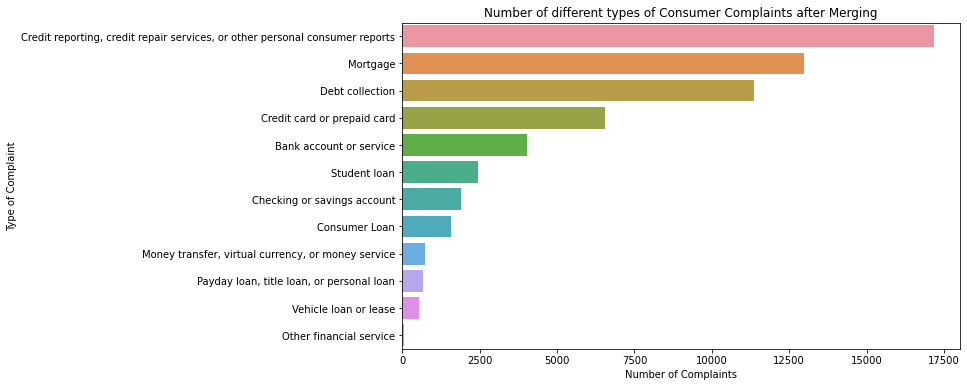

In [6]:
plt.figure(figsize=(10,6))
sns.barplot(x=df["Product"].value_counts(),y=df["Product"].value_counts().index)
plt.title("Number of different types of Consumer Complaints after Merging")
plt.xlabel("Number of Complaints")
plt.ylabel("Type of Complaint")

Text(0, 0.5, 'Type of Complaint')

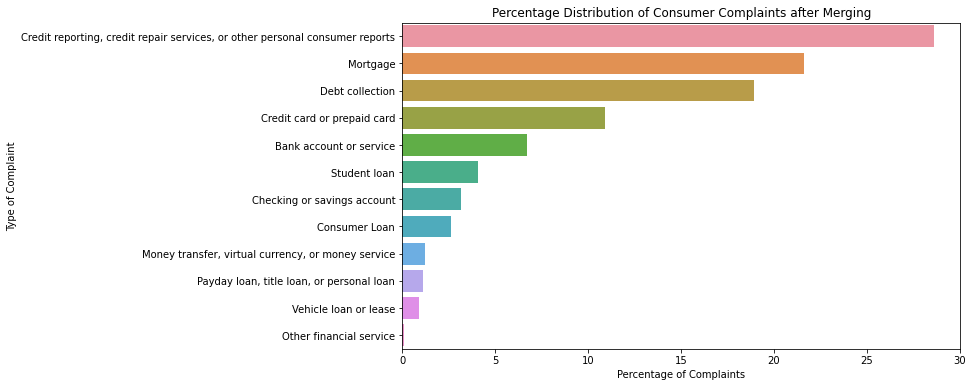

In [7]:
plt.figure(figsize=(10,6))
sns.barplot(x=(df["Product"].value_counts()/df.shape[0])*100,y=df["Product"].value_counts().index)
plt.title("Percentage Distribution of Consumer Complaints after Merging")
plt.xlabel("Percentage of Complaints")
plt.ylabel("Type of Complaint")

Feature Engineering

In [8]:
# replace missing values with an empty string
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].fillna('')

# compute the number of words and length for each row
num_words = []
length = []
for i in range(df.shape[0]):
    text = df['Consumer complaint narrative'].iloc[i]
    num_words.append(len(list(text.split())))
    length.append(len(list(text)))

# add the new columns to the DataFrame
df['Word Count'] = num_words
df['Length'] = length


In [9]:
num_words=[]
length=[]
for i in range (df.shape[0]):
    num_words.append((len(list(df["Consumer complaint narrative"].iloc[i].split()))))
    length.append((len(list(df["Consumer complaint narrative"].iloc[i]))))

df["Word Count"]=num_words
df["Length of complaint"]=length
df["Characters/Word"]=df["Length of complaint"]/df["Word Count"]
     


Text(0.5, 1.0, 'Distribution of Word Count for different Types of Complaints')

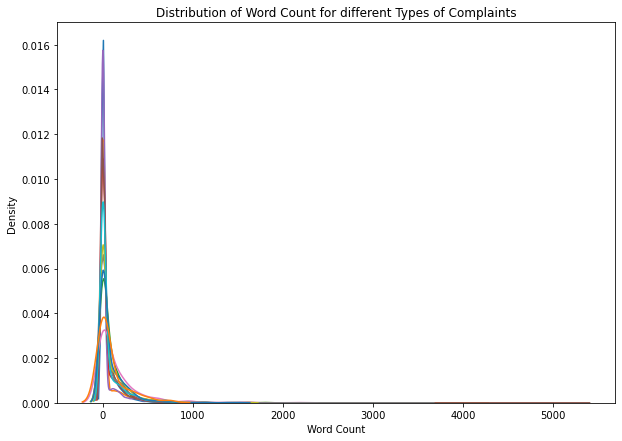

In [10]:
plt.figure(figsize=(10,7))
for p in df["Product"].unique():
  sns.kdeplot(df[df["Product"]==p]["Word Count"],label=p)
plt.title("Distribution of Word Count for different Types of Complaints")

Text(0.5, 1.0, 'Distribution of Length of different Types of Complaints')

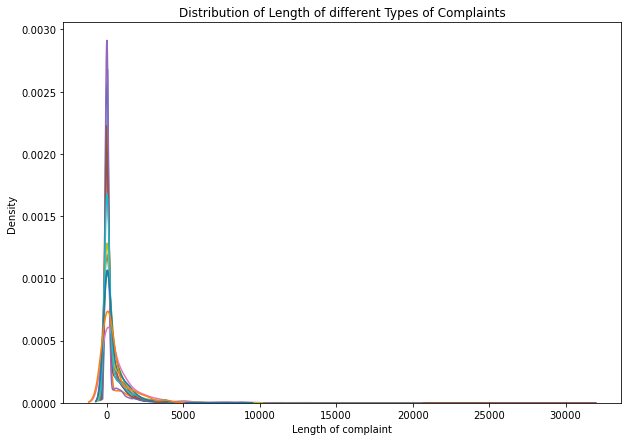

In [11]:
plt.figure(figsize=(10,7))
for p in df["Product"].unique():
  sns.kdeplot(df[df["Product"]==p]["Length of complaint"],label=p)
plt.title("Distribution of Length of different Types of Complaints")
     

Text(0.5, 1.0, 'Distribution of Characters per Word for different types of Cases')

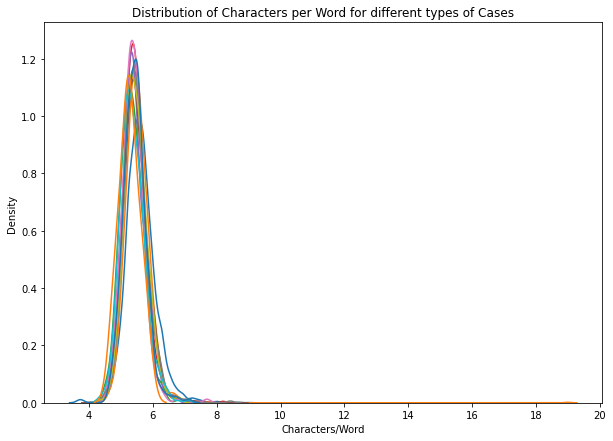

In [12]:
plt.figure(figsize=(10,7))
for p in df["Product"].unique():
  sns.kdeplot(df[df["Product"]==p]["Characters/Word"],label=p)
plt.title("Distribution of Characters per Word for different types of Cases")

In [13]:
data=df["Consumer complaint narrative"].tolist()
stuff_to_be_removed = list(stopwords.words("english"))+list(punctuation)
final_corpus=[]
for i in range(len(data)):
    text=word_tokenize(data[i].lower())
    text = [t for t in text if len(t)>3]
    text=[re.sub(r'[xx]*', '',t) for t in text]
    text=[re.sub(r'//', '',t) for t in text]
    text=[w for w in text if w not in stuff_to_be_removed]
    sent=" ".join(text)
    final_corpus.append(sent)
     

eda_df=pd.DataFrame(final_corpus,columns=["Complaints"])
eda_df["Product"]=df["Product"].tolist()

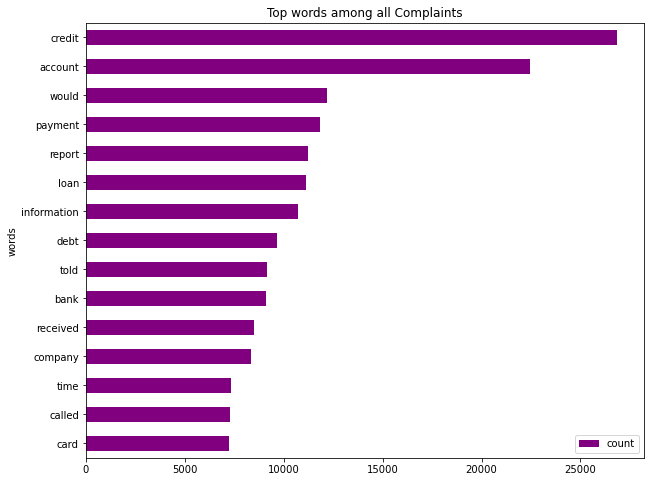

In [14]:
import itertools
import collections
def top_words(corpus):
  words = [word.lower().split() for word in eda_df['Complaints']]
  all_words = list(itertools.chain(*words))
  counts = collections.Counter(all_words)
  df1 = pd.DataFrame(counts.most_common(15),columns=['words', 'count'])
  return df1
df1 = top_words(eda_df['Complaints'])
def plot_top_words(df1):
  fig, ax = plt.subplots(figsize=(10, 8))
  plt.title('Top words among all Complaints')
  df1.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="purple")

plot_top_words(df1)

<AxesSubplot:title={'center':'Top bigrams among all types of Complaints'}, ylabel='words'>

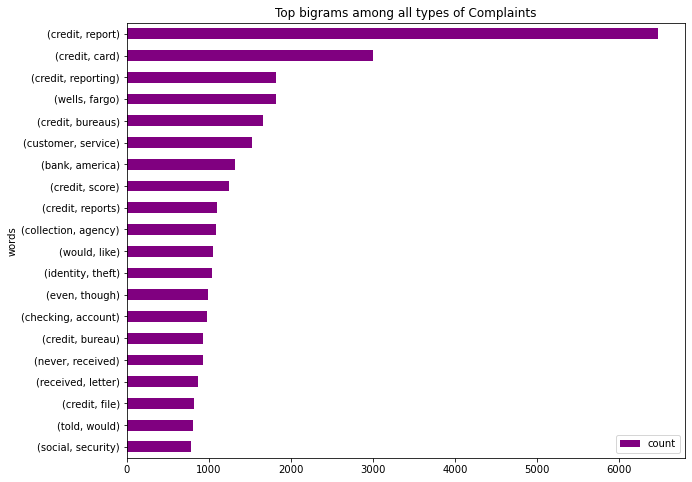

In [15]:
from nltk import bigrams, trigrams
def Bigrams(corpus):
  words = [word.lower().split() for word in corpus]
  words = [list(bigrams(word)) for word in words]
  all_words = list(itertools.chain(*words))
  counts = collections.Counter(all_words)
  df1 = pd.DataFrame(counts.most_common(20),columns=['words', 'count'])
  return df1

df1 = Bigrams(eda_df['Complaints'])
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Top bigrams among all types of Complaints')
df1.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="purple")

<AxesSubplot:title={'center':'Top Trigrams among all type of Complaints'}, ylabel='words'>

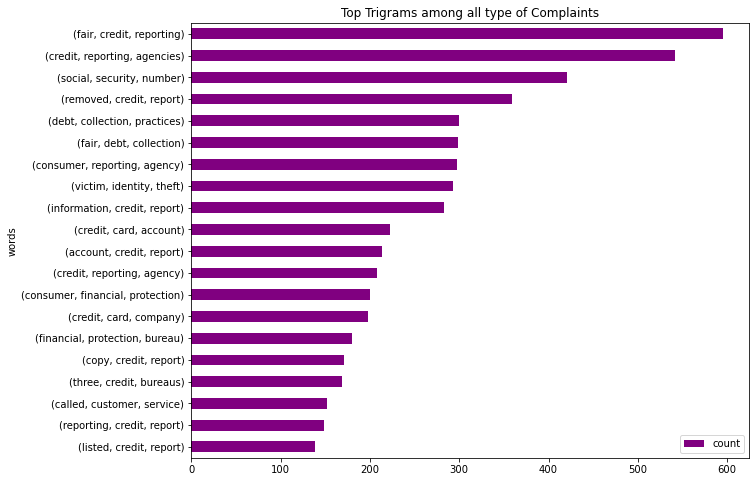

In [16]:
def Trigrams(corpus):
  words = [word.lower().split() for word in corpus]
  words = [list(trigrams(word)) for word in words]
  all_words = list(itertools.chain(*words))
  counts = collections.Counter(all_words)
  df1 = pd.DataFrame(counts.most_common(20),columns=['words', 'count'])
  return df1
df1 = Trigrams(eda_df['Complaints'])
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Top Trigrams among all type of Complaints')
df1.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="purple")

Data Cleaning Stemming and Lemmatizing

In [17]:
def cleaning_text(text):
   text = text.lower()
   text = re.sub('', '', text)
  #  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
   text = re.sub('\w*\d\w*', '', text)
   text = re.sub(r'[xx]*', '',text)
   text = re.sub(r'\b\w\b','',text)
   text = re.sub(r'//','',text)
   text = re.sub(r'^\s+|\s$','',text)
   text = re.sub(r'\s+',' ',text)
   text = re.sub(r'\*',' ',text)
   return text
clean_text = lambda x: cleaning_text(x)
     

lancaster_stemmer = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [18]:
function_cleaned=df["Consumer complaint narrative"].apply(clean_text)
     

cleaned_stemmed=[lancaster_stemmer.stem(w) for w in function_cleaned]
cleaned_lemmatized=[wordnet_lemmatizer.lemmatize(w) for w in function_cleaned]
     

new_df_stemmed=pd.DataFrame(cleaned_stemmed,columns=["Complaints"])
     

new_df_lemmatized=pd.DataFrame(cleaned_lemmatized,columns=["Complaints"])
     

labels=df["Product"].tolist()
new_df_stemmed["Product"]=labels
new_df_lemmatized["Product"]=labels
     

le=LabelEncoder()
new_df_stemmed["Product"]=le.fit_transform(new_df_stemmed["Product"])
new_df_lemmatized["Product"]=le.fit_transform(new_df_lemmatized["Product"])
     

In [19]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
     

cv=CountVectorizer(stop_words='english')
tfidf=TfidfVectorizer(stop_words='english')
     

vector_cv_stemmed=cv.fit_transform(new_df_stemmed["Complaints"])
vector_cv_lemmatized=cv.fit_transform(new_df_lemmatized["Complaints"])
vector_tfidf_stemmed=tfidf.fit_transform(new_df_stemmed["Complaints"])
vector_tfidf_lemmatized=tfidf.fit_transform(new_df_lemmatized["Complaints"])

In [20]:
X1=vector_cv_stemmed
X2=vector_tfidf_stemmed
y=new_df_stemmed["Product"]

In [21]:
from sklearn.model_selection import train_test_split as tts
X_train_s,X_test_s,y_train_s,y_test_s=tts(X1,y,test_size=0.25,random_state=0)
X_train_l,X_test_l,y_train_l,y_test_l=tts(X2,y,test_size=0.25,random_state=0)

In [22]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [23]:
ro=RandomOverSampler(random_state=42)
sm=SMOTE(random_state=42)
X_train_scro,y_train_scro=ro.fit_resample(X_train_s,y_train_s)
X_train_scsm,y_train_scsm=sm.fit_resample(X_train_s,y_train_s)
X_train_stro,y_train_stro=ro.fit_resample(X_train_l,y_train_l)
X_train_stsm,y_train_stsm=sm.fit_resample(X_train_l,y_train_l)

Lancaster Stemmer - Count Vectorizer and TF-IDF Vectorizer - Random Oversampling and SMOTE

In [24]:
nb_scro=MultinomialNB()
nb_scsm=MultinomialNB()
nb_stro=MultinomialNB()
nb_stsm=MultinomialNB()

In [25]:
nb_scro.fit(X_train_scro,y_train_scro)
nb_scsm.fit(X_train_scsm,y_train_scsm)
nb_stro.fit(X_train_stro,y_train_stro)
nb_stsm.fit(X_train_stsm,y_train_stsm)

MultinomialNB()

In [26]:
nb_scro.fit(X_train_scro,y_train_scro)
nb_scsm.fit(X_train_scsm,y_train_scsm)
nb_stro.fit(X_train_stro,y_train_stro)
nb_stsm.fit(X_train_stsm,y_train_stsm)

MultinomialNB()

In [27]:
y_pred_nb1=nb_scro.predict(X_test_s)
y_pred_nb2=nb_scsm.predict(X_test_s)
y_pred_nb3=nb_stro.predict(X_test_s)
y_pred_nb4=nb_stsm.predict(X_test_s)
     

print("F1-Score of Stammer-Count Vectorizer-Random Oversampling: ",f1_score(y_test_s,y_pred_nb1,average='weighted'))
print("F1-Score of Stammer-Count Vectorizer-SMOTE: ",f1_score(y_test_s,y_pred_nb2,average='weighted'))
print("F1-Score of Stammer-TF_IDF Vectorizer-Random Oversampling: ",f1_score(y_test_s,y_pred_nb3,average='weighted'))
print("F1-Score of Stammer-TF_IDF Vectorizer-SMOTE: ",f1_score(y_test_s,y_pred_nb4,average='weighted'))

F1-Score of Stammer-Count Vectorizer-Random Oversampling:  0.34897099236334095
F1-Score of Stammer-Count Vectorizer-SMOTE:  0.3495389964436394
F1-Score of Stammer-TF_IDF Vectorizer-Random Oversampling:  0.3174926246426637
F1-Score of Stammer-TF_IDF Vectorizer-SMOTE:  0.3370966636752051


In [28]:
print("Average 5-Fold Cross validated F1-Score of Stammer-Count Vectorizer-Random Oversampling: ",
      cross_val_score(estimator=nb_scro,X=X1,y=y,cv=5,scoring='f1_weighted').mean())
print("Average 5-Fold Cross validated F1-Score of Stammer-Count Vectorizer-SMOTE: ",
      cross_val_score(estimator=nb_scsm,X=X1,y=y,cv=5,scoring='f1_weighted').mean())
print("Average 5-Fold Cross validated F1-Score of Stammer-TF_IDF Vectorizer-Random Oversampling: ",
      cross_val_score(estimator=nb_stro,X=X2,y=y,cv=5,scoring='f1_weighted').mean())
print("Average 5-Fold Cross validated F1-Score of Stammer-TF_IDF Vectorizer-SMOTE: ",
      cross_val_score(estimator=nb_stsm,X=X2,y=y,cv=5,scoring='f1_weighted').mean())

Average 5-Fold Cross validated F1-Score of Stammer-Count Vectorizer-Random Oversampling:  0.3614083153385761
Average 5-Fold Cross validated F1-Score of Stammer-Count Vectorizer-SMOTE:  0.3614083153385761
Average 5-Fold Cross validated F1-Score of Stammer-TF_IDF Vectorizer-Random Oversampling:  0.2877905560703936
Average 5-Fold Cross validated F1-Score of Stammer-TF_IDF Vectorizer-SMOTE:  0.2877905560703936


WordNet Lemmatizer - Count and TF-IDF Vectorizer - Random Oversampling and SMOTE

In [29]:
X3=vector_cv_lemmatized
X4=vector_tfidf_lemmatized
y=new_df_lemmatized["Product"]
     

from sklearn.model_selection import train_test_split as tts
X_train_lc,X_test_lc,y_train_lc,y_test_lc=tts(X3,y,test_size=0.25,random_state=0)
X_train_lt,X_test_lt,y_train_lt,y_test_lt=tts(X4,y,test_size=0.25,random_state=0)
     

X_train_lcro,y_train_lcro=ro.fit_resample(X_train_lc,y_train_lc)
X_train_lcsm,y_train_lcsm=sm.fit_resample(X_train_lc,y_train_lc)
X_train_ltro,y_train_ltro=ro.fit_resample(X_train_lt,y_train_lt)
X_train_ltsm,y_train_ltsm=sm.fit_resample(X_train_lt,y_train_lt)

In [30]:
nb_lcro=MultinomialNB()
nb_lcsm=MultinomialNB()
nb_ltro=MultinomialNB()
nb_ltsm=MultinomialNB()
     

nb_lcro.fit(X_train_lcro,y_train_lcro)
nb_lcsm.fit(X_train_lcsm,y_train_lcsm)
nb_ltro.fit(X_train_ltro,y_train_ltro)
nb_ltsm.fit(X_train_ltsm,y_train_ltsm)

MultinomialNB()

In [31]:
y_pred_nb5=nb_lcro.predict(X_test_lc)
y_pred_nb6=nb_lcsm.predict(X_test_lc)
y_pred_nb7=nb_ltro.predict(X_test_lt)
y_pred_nb8=nb_ltsm.predict(X_test_lt)
     

print("F1-Score of Lemmatizer-Count Vectorizer-Random Oversampling: ",f1_score(y_test_lc,y_pred_nb5,average='weighted'))
print("F1-Score of Lemmatizer-Count Vectorizer-SMOTE: ",f1_score(y_test_lc,y_pred_nb6,average='weighted'))
print("F1-Score of Lemmatizer-TF_IDF Vectorizer-Random Oversampling: ",f1_score(y_test_lt,y_pred_nb7,average='weighted'))
print("F1-Score of Lemmatizer-TF_IDF Vectorizer-SMOTE: ",f1_score(y_test_lt,y_pred_nb8,average='weighted'))

F1-Score of Lemmatizer-Count Vectorizer-Random Oversampling:  0.34875235541431693
F1-Score of Lemmatizer-Count Vectorizer-SMOTE:  0.3494679077498003
F1-Score of Lemmatizer-TF_IDF Vectorizer-Random Oversampling:  0.3224894287622665
F1-Score of Lemmatizer-TF_IDF Vectorizer-SMOTE:  0.33864557068668655


In [32]:
print("Average 5-Fold Cross validated F1-Score of Stammer-Count Vectorizer-Random Oversampling: ",
      cross_val_score(estimator=nb_lcro,X=X3,y=y,cv=5,scoring='f1_weighted').mean())
print("Average 5-Fold Cross validated F1-Score of Stammer-Count Vectorizer-SMOTE: ",
      cross_val_score(estimator=nb_lcsm,X=X3,y=y,cv=5,scoring='f1_weighted').mean())
print("Average 5-Fold Cross validated F1-Score of Stammer-TF_IDF Vectorizer-Random Oversampling: ",
       cross_val_score(estimator=nb_ltro,X=X4,y=y,cv=5,scoring='f1_weighted').mean())
print("Average 5-Fold Cross validated F1-Score of Stammer-TF_IDF Vectorizer-SMOTE: ",
       cross_val_score(estimator=nb_ltsm,X=X4,y=y,cv=5,scoring='f1_weighted').mean())

Average 5-Fold Cross validated F1-Score of Stammer-Count Vectorizer-Random Oversampling:  0.36134976401606733
Average 5-Fold Cross validated F1-Score of Stammer-Count Vectorizer-SMOTE:  0.36134976401606733
Average 5-Fold Cross validated F1-Score of Stammer-TF_IDF Vectorizer-Random Oversampling:  0.28785894141154056
Average 5-Fold Cross validated F1-Score of Stammer-TF_IDF Vectorizer-SMOTE:  0.28785894141154056


Topic Modelling
Let's perform topic modeling for "Vehicle loan or lease" type complaints, since the proportion of these type of complaints are very less.

Latent Semantic Analysis

In [33]:
new_df_stemmed["Product"]=le.inverse_transform(new_df_stemmed["Product"])
new_df_lemmatized["Product"]=le.inverse_transform(new_df_lemmatized["Product"])
     

vehicle_complaints_stemmed=new_df_stemmed[new_df_stemmed["Product"]=="Vehicle loan or lease"]
vehicle_complaints_lemmatized=new_df_lemmatized[new_df_lemmatized["Product"]=="Vehicle loan or lease"]
     

from sklearn.decomposition import TruncatedSVD
from pprint import pprint
     

X_cv=cv.fit_transform(vehicle_complaints_stemmed["Complaints"])
X_tfidf=tfidf.fit_transform(vehicle_complaints_stemmed["Complaints"])
     

svd_cv = TruncatedSVD(n_components=5,n_iter=100,random_state=6)
svd_tfidf = TruncatedSVD(n_components=5,n_iter=100,random_state=6)
     

svd_cv.fit(X_cv)
svd_tfidf.fit(X_tfidf)

TruncatedSVD(n_components=5, n_iter=100, random_state=6)

In [34]:
terms=cv.get_feature_names()
for i,comp in enumerate(svd_cv.components_):
  terms_comp = zip(terms,comp)
  sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
  pprint("Topic "+str(i)+": ")
  pprint(sorted_terms)

'Topic 0: '
[('payment', 0.29812190241494024),
 ('loan', 0.28508656515794),
 ('told', 0.28172629725938103),
 ('credit', 0.27842325220819075),
 ('car', 0.25902729044917366),
 ('account', 0.20496226022233896),
 ('called', 0.18503457315880956),
 ('payments', 0.17746336886245714),
 ('said', 0.16592447777896926),
 ('did', 0.15118807090629421)]
'Topic 1: '
[('car', 0.5088646143395191),
 ('contract', 0.2511256191901052),
 ('vehicle', 0.23266351679624953),
 ('new', 0.15800297129683016),
 ('did', 0.13031661768889258),
 ('total', 0.11169996860706337),
 ('trade', 0.095666676773455),
 ('loan', 0.08624600661342642),
 ('dealer', 0.0860041334585259),
 ('warranty', 0.08478810748320194)]
'Topic 2: '
[('told', 0.2837747536086009),
 ('called', 0.22720034228751654),
 ('said', 0.21673105938956028),
 ('fargo', 0.17796811860163672),
 ('wells', 0.17787785808401088),
 ('charge', 0.14563397460677643),
 ('resume', 0.10987800022214338),
 ('days', 0.10805635180371126),
 ('loan', 0.10673684946020123),
 ('payment', 

C:\Users\Master\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [35]:
terms=tfidf.get_feature_names()
for i,comp in enumerate(svd_tfidf.components_):
  terms_comp = zip(terms,comp)
  sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
  pprint("Topic "+str(i)+": ")
  pprint(sorted_terms)

'Topic 0: '
[('payment', 0.27657843550253935),
 ('car', 0.24725731101500803),
 ('credit', 0.22569945726268145),
 ('loan', 0.21728426793148506),
 ('vehicle', 0.19701897917931546),
 ('payments', 0.17773747245523933),
 ('account', 0.1731421851218304),
 ('told', 0.16404510798707064),
 ('late', 0.14075478956055396),
 ('called', 0.1274825783415962)]
'Topic 1: '
[('payment', 0.3820181207295319),
 ('late', 0.27773604779681754),
 ('account', 0.21502392406929668),
 ('payments', 0.16485915798684467),
 ('days', 0.13663330706761637),
 ('online', 0.09553707242114706),
 ('check', 0.08575989426679069),
 ('phone', 0.07811267726821836),
 ('principal', 0.07298946090710509),
 ('bmw', 0.05940700364186542)]
'Topic 2: '
[('credit', 0.4103821584364776),
 ('reporting', 0.24197682986613792),
 ('report', 0.23824083373718696),
 ('financial', 0.2201937138858115),
 ('gm', 0.20659098389936714),
 ('vehicle', 0.19243453550579617),
 ('account', 0.17468854109225238),
 ('late', 0.12180867110140757),
 ('reported', 0.10899

Linear Discriminant Analysis

In [36]:
words = [word_tokenize(text) for text in eda_df[eda_df["Product"]=="Vehicle loan or lease"]["Complaints"]]
dictionary = corpora.Dictionary(words)
     

doc_term_matrix = [dictionary.doc2bow(doc) for doc in words]
     

lda = LdaModel(corpus=doc_term_matrix,num_topics=5,id2word=dictionary,passes=50)
     

pprint(lda.print_topics(num_topics=5,num_words=10))

[(0,
  '0.015*"vehicle" + 0.013*"loan" + 0.010*"would" + 0.009*"contract" + '
  '0.008*"told" + 0.008*"credit" + 0.008*"dealership" + 0.007*"time" + '
  '0.006*"lease" + 0.006*"said"'),
 (1,
  '0.023*"payment" + 0.017*"credit" + 0.016*"loan" + 0.014*"account" + '
  '0.013*"told" + 0.012*"payments" + 0.012*"would" + 0.010*"called" + '
  '0.009*"late" + 0.008*"bank"'),
 (2,
  '0.015*"vehicle" + 0.010*"credit" + 0.009*"boat" + 0.008*"company" + '
  '0.008*"amount" + 0.007*"balance" + 0.007*"payment" + 0.006*"insurance" + '
  '0.006*"sent" + 0.006*"made"'),
 (3,
  '0.013*"vehicle" + 0.011*"credit" + 0.010*"would" + 0.008*"called" + '
  '0.008*"debt" + 0.007*"told" + 0.007*"report" + 0.006*"information" + '
  '0.006*"repossessed" + 0.006*"company"'),
 (4,
  '0.008*"company" + 0.007*"would" + 0.006*"phone" + 0.006*"dealer" + '
  '0.005*"honda" + 0.005*"payments" + 0.005*"finance" + 0.005*"shows" + '
  '0.004*"took" + 0.004*"vehicle"')]
